In [328]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# dark background
plt.style.use('dark_background')

def get_v_bounds(X, Y, Z):

    phi_where_v_turns = [np.arctan(Y/Z)]

    if phi_where_v_turns[0] < np.pi:
        phi_where_v_turns.append(np.arctan(Y/Z) + np.pi)
    elif phi_where_v_turns[0] > np.pi:
        phi_where_v_turns.append(np.arctan(Y/Z) - np.pi)

    for i in range(2):
        if phi_where_v_turns[i] < 0:
            print("phi < 0")
            phi_where_v_turns[i] = phi_where_v_turns[i] + 2 * np.pi
        elif phi_where_v_turns[i] > 2 * np.pi:
            print("phi > 2pi")
            phi_where_v_turns[i] = phi_where_v_turns[i] - 2 * np.pi

    zero_v = v_phi(phi_where_v_turns, X, Y, Z)    

    signum = np.sign( - np.sin(phi_where_v_turns) * Y - np.cos(phi_where_v_turns) * Z)
    
    return phi_where_v_turns, zero_v, signum

def get_phi_bounds(phi, A, B, C, X, Y, Z):

    a, b = B/A, C/A

    bounds = []
    for n in range(-2, 3):

        _ = a**2 + b**2 - 1 
        
        if _ > 0:
            b1 = 2 * (np.arctan((a - np.sqrt(_)) / (b - 1)) + n * np.pi)
            if (b1 > 0) & (b1 < 2 * np.pi):
                bounds.append(b1)
            b2 = 2 * (np.arctan((a + np.sqrt(a**2 + b**2 - 1)) / (b - 1)) + n * np.pi)
            if (b2 > 0) & (b2 < 2 * np.pi):
                bounds.append(b2)

    # derivative of the function gets us which side of the bound to include
    bounds = np.sort(np.array(bounds))

    # get the derivative dx/dphi
    dx_dphi_at_bounds = np.sign(dx_dphi(bounds, B, C))

    # print(bounds, dx_dphi_at_bounds)

    def bounds_mask(phi):

        default = (phi < 2 * np.pi) & (phi > 0)

        mark = 1 # we start inclusive at 0

        for bound, dx_dphi_at_bound in zip(bounds, dx_dphi_at_bounds):

            if dx_dphi_at_bound == 1:

                if mark == 1:
                    # print("1")
                    default = default & (phi >bound)
                    mark = 1
                    # print("We are already inclusive, but the slope is positive, "
                    #       "so we must be at the beginning of the full interval")

                elif mark == 0:
                    # print("2")
                    default = default | (phi > bound)
                    mark = 1
                    # print("The slope has been negative, changes to positive, "
                    #       "so we must be at the beginning of an included interval")

            elif dx_dphi_at_bound == -1:

                if mark == 1:
                    # print("3")
                    default = default & (phi < bound)
                    mark = 0
                    # print("We are already inclusive, but the slope is negative, "
                    #       "so we must be at the end of the included interval.")

                elif mark == 0:
                    raise ValueError('negative slope although we already have a negative slope')

        return default
    
    bounds_v = v_phi(bounds, X, Y, Z)

    return bounds, bounds_v, dx_dphi_at_bounds, bounds_mask(phi)


def x_params(phi, alpha, i_rot, i_mag, latitude):
    sa, ca = np.sin(alpha), np.cos(alpha)
    si, ci = np.sin(i_rot), np.cos(i_rot)
    st, ct = np.sin(latitude), np.cos(latitude)
    sp, cp = np.sin(phi), np.cos(phi)
    sip, cip = np.sin(i_rot + i_mag), np.cos(i_rot + i_mag)


    A = ct * (sip * (si * sa**2 + ca) + cip * si * ci * sa**2)
    B = st * (cip * (si * sa**2 + ca) - sip * si * ci * sa**2)
    C = - sa * ci * st

    return A, B, C

def vx_params(phi, alpha, i_rot, i_mag, latitude):
    sa, ca = np.sin(alpha), np.cos(alpha)
    si, ci = np.sin(i_rot), np.cos(i_rot)
    st, ct = np.sin(latitude), np.cos(latitude)
    sp, cp = np.sin(phi), np.cos(phi)
    sip, cip = np.sin(i_rot + i_mag), np.cos(i_rot + i_mag)

    X = -sa * sip * ct + 2 * ca * sa * ct * si * (sip + ci * cip)
    Y = -sa * cip * st + 2 * ca * sa * st * (cip * si - sip)
    Z = -ca * ci * st

    return X, Y, Z



def v_phi(phi, X, Y, Z):
    return Y * np.sin(phi) + Z * np.cos(phi) + X


def flux_at_x_vx(vx, X, Y, Z):

    flux = 1/ np.sqrt(-(vx - X)**2 + Y**2 + Z**2 + .05)

    # flux[flux>10] = 10

    return flux


def phi_v(v, X, Y, Z):
    n, m = 1, 0
    phi1 = 2 * (np.arctan((Y - np.sqrt(-v**2 + 2 * v * X - X**2 + Y**2 + Z**2)) / (v - X + Z) ) + n * np.pi)
    phi2 = 2 * (np.arctan((Y + np.sqrt(-v**2 + 2 * v * X - X**2 + Y**2 + Z**2)) / (v - X + Z) ) + m * np.pi)

    return phi1, phi2

def x_phi(phi, A, B, C):
    return B * np.sin(phi) + C * np.cos(phi) + A

def dx_dphi(phi, B, C):
    return B * np.cos(phi) - C * np.sin(phi)


phi < 0
[ True  True  True  True]
minimum
maximum
[5.33461409 2.19302144] [-0.90325932  1.33862505]


(0.0, 6.283185307179586)

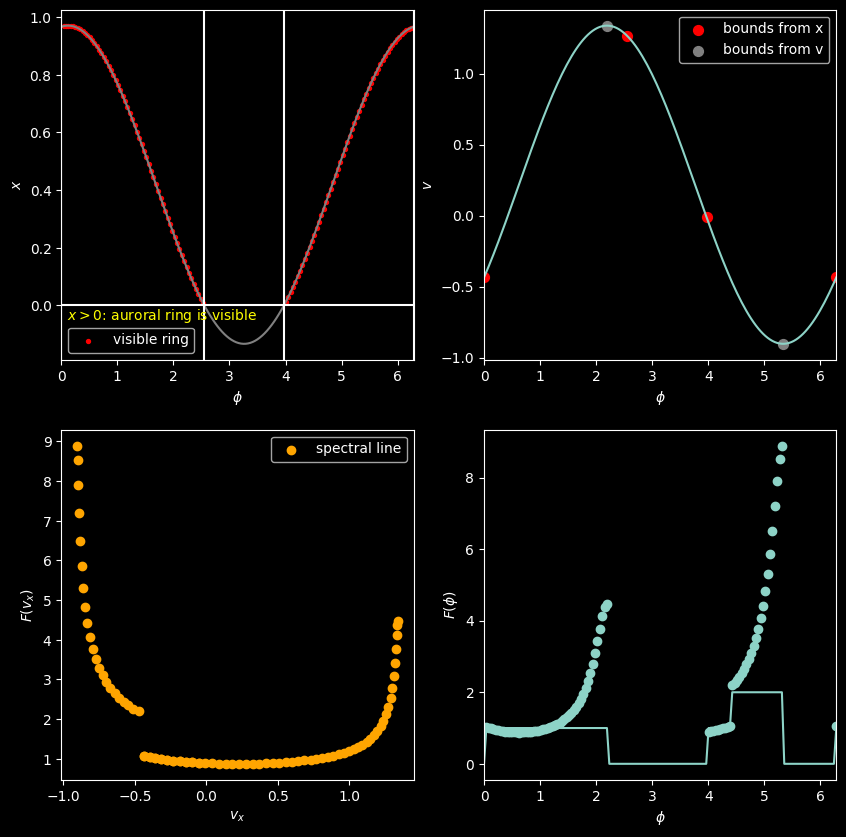

In [343]:

def get_spectral_line(phi, i_rot, i_mag, latitude, alpha):

    A, B, C = x_params(phi, alpha, i_rot=i_rot, i_mag=i_mag, latitude=latitude)

    X, Y, Z = vx_params(phi, alpha, i_rot=i_rot, i_mag=i_mag, latitude=latitude)

    v = v_phi(phi, X, Y, Z)

    phi_bounds, phi_bounds_v, signum, mask = get_phi_bounds(phi, A, B, C, X, Y, Z)

    phi_bounds = np.insert(phi_bounds, 0, 0)
    phi_bounds = np.insert(phi_bounds, -1, 2*np.pi)

    # add phi_bounds_v
    phi_bounds_v = np.insert(phi_bounds_v, 0, v_phi(0, X, Y, Z))
    phi_bounds_v = np.insert(phi_bounds_v, -1, v_phi(2* np.pi, X, Y, Z))

    # add signum
    signum = np.insert(signum, 0, np.sign(dx_dphi(phi_bounds[0], B, C)))
    signum = np.insert(signum, -1, np.sign(dx_dphi(phi_bounds[-1], B, C)))

    # v_bounds
    v_bounds_phi, v_bounds, signum_v = get_v_bounds(X, Y, Z)

    assert v_bounds.shape[0] == 2

    flux = flux_at_x_vx(v, X, Y, Z)

    # make flux_mask from mask
    fluxmask = np.copy(mask).astype(int)

    _vb, _vbp, _sv = np.copy(v_bounds), np.copy(v_bounds_phi), np.copy(signum_v)

    for i in range(1,len(phi_bounds)):

        # print(phi_bounds[i], v_bounds_phi[0], signum_v[0])

        try:
    
            if (phi_bounds[i] > v_bounds_phi[0]) & (signum_v[0] == -1): # maximum
                phi_rel_on = (phi > phi_bounds[i-1]) & (phi < v_bounds_phi[0])
                phi_rel_off = (phi < phi_bounds[i]) & (phi > v_bounds_phi[0])
                pos_diff = (v_bounds[0] > phi_bounds_v)
                next_v_level = np.argmin(v_bounds[0] - phi_bounds_v[pos_diff])
                between_v = (v > phi_bounds_v[pos_diff][next_v_level]) & (v < v_bounds[0])
                fluxmask[phi_rel_on & between_v] = 2
                fluxmask[phi_rel_off & between_v] = 0
                print("maximum")

                # delete v_bounds_phi[0], signum_v[0] and v_bounds[0] from their arrays
                v_bounds_phi = np.delete(v_bounds_phi, 0)
                signum_v = np.delete(signum_v, 0)
                v_bounds = np.delete(v_bounds, 0)

            if (phi_bounds[i] > v_bounds_phi[0]) & (signum_v[0] == 1): # minimum
                phi_rel_on = (phi > phi_bounds[i-1]) & (phi < v_bounds_phi[0])
                phi_rel_off = (phi < phi_bounds[i]) & (phi > v_bounds_phi[0])
                pos_diff = (v_bounds[0] < phi_bounds_v)

                print(pos_diff)
                next_v_level = np.argmin(phi_bounds_v[pos_diff] - v_bounds[0])
                between_v = (v > v_bounds[0]) & (v < phi_bounds_v[pos_diff][next_v_level])
                fluxmask[phi_rel_on & between_v] = 2
                fluxmask[phi_rel_off & between_v] = 0
                print("minimum")

                # delete v_bounds_phi[0], signum_v[0] and v_bounds[0] from their arrays
                v_bounds_phi = np.delete(v_bounds_phi, 0)
                signum_v = np.delete(signum_v, 0)
                v_bounds = np.delete(v_bounds, 0)

        except IndexError:
            pass
    return phi_bounds, phi_bounds_v, signum, _vbp, _vb, flux, fluxmask, mask, v, phi, A, B, C


phi = np.linspace(0, 2*np.pi, 150)

# inclination of rotation axis in radians with the right convention
i_rot = np.pi/2 - 80 * np.pi/180

# inclination of magnetic axis in radians relative to rotation axis
i_mag = 70 * np.pi/180

# latitude of the ring in radians
latitude = 60 * np.pi/180


# go through phi_bound

fig, axes = plt.subplots(2,2,figsize=(10, 10))
axes = axes.flatten()

res = get_spectral_line(phi, i_rot, i_mag, latitude, 5.585053606381854)
        
phi_bounds, phi_bounds_v, signum, v_bounds_phi, v_bounds, flux, fluxmask, mask, v, phi, A, B, C = res

print(v_bounds_phi, v_bounds)

axes[0].plot(phi, x_phi(phi, A, B, C), c="grey")
axes[0].axhline(0, color='w')


axes[0].scatter(phi[mask], x_phi(phi, A, B, C)[mask], color='r', s=8, label="visible ring")

for bs in phi_bounds:
    # print(bs)
    axes[0].axvline(bs, color='w')


axes[0].set_xlim(0, 2*np.pi)
axes[0].set_xlabel(r'$\phi$')
axes[0].set_ylabel(r'$x$')
axes[0].legend()

# add text to the plot that indicates that for x>0 the auroral ring is visible
axes[0].text(0.1, -0.05, r'$x>0$: auroral ring is visible', color='yellow', fontsize=10)

axes[1].plot(phi, v)
axes[1].set_xlabel(r'$\phi$')
axes[1].set_ylabel(r'$v$')
axes[1].set_xlim(0, 2*np.pi)

axes[1].scatter(phi_bounds, phi_bounds_v, color='r', s=50, label="bounds from x")
axes[1].scatter(v_bounds_phi, v_bounds, color='grey', s=50, label="bounds from v")
axes[1].legend()




axes[2].scatter(v[fluxmask!=0], (flux*fluxmask)[fluxmask!=0], c="orange", 
                label="spectral line")
axes[2].set_xlabel(r'$v_x$')
axes[2].set_ylabel(r'$F(v_x)$')
axes[2].legend()

axes[3].plot(phi, fluxmask)
axes[3].scatter(phi[fluxmask!=0], (flux*fluxmask)[fluxmask!=0])
axes[3].set_xlabel(r'$\phi$')
axes[3].set_ylabel(r'$F(\phi)$')
axes[3].set_xlim(0, 2*np.pi)




In [316]:
phi = np.linspace(0, 2*np.pi, 150)

# inclination of rotation axis in radians with the right convention
i_rot = np.pi/2 - 80 * np.pi/180

# inclination of magnetic axis in radians relative to rotation axis
i_mag = 70 * np.pi/180

# latitude of the ring in radians
latitude = 60 * np.pi/180

# alpha=np.pi/3

# go through phi_bound

# fig, axes = plt.subplots(1,1,figsize=(10, 10))
# axes = axes.flatten()

fluxes = []
vs = []

for alpha in np.linspace(0, 2*np.pi,10):
    res = get_spectral_line(phi, i_rot, i_mag, latitude, alpha)
    print(alpha)
    phi_bounds, phi_bounds_v, signum, v_bounds_phi, v_bounds, flux, fluxmask, mask, v, phi, A, B, C = res

    fluxes.append((flux*fluxmask)[mask])
    vs.append(v[mask])

# make a dataframe from vs and fluxes
df = pd.DataFrame({'v': np.concatenate(vs), 'flux': np.concatenate(fluxes)})

# bin in v space and sum fluxes
df_binned = df.groupby(pd.cut(df.v, bins=300)).sum()

# plot
df_binned.index = pd.IntervalIndex(df_binned.index).mid

plt.plot(df_binned.index.values,  df_binned.flux.values)

0.0
[ True  True  True  True]
minimum
maximum
0.6981317007977318
[ True  True  True  True]
minimum
maximum
1.3962634015954636
maximum
[ True  True  True  True]
minimum
2.0943951023931953
2.792526803190927
maximum
3.490658503988659
maximum
[ True  True  True  True]
minimum
4.1887902047863905
[ True  True  True  True]
minimum
maximum
4.886921905584122
[ True  True  True  True]
minimum
maximum
5.585053606381854
[False False]


ValueError: attempt to get argmin of an empty sequence

## Archive

/tmp/ipykernel_8901/664797790.py:5: RuntimeWarning: invalid value encountered in sqrt
  phi1 = 2 * (np.arctan((Y - np.sqrt(-v**2 + 2 * v * X - X**2 + Y**2 + Z**2)) / (v - X + Z) ) + n * np.pi)
/tmp/ipykernel_8901/664797790.py:6: RuntimeWarning: invalid value encountered in sqrt
  phi2 = 2 * (np.arctan((Y + np.sqrt(-v**2 + 2 * v * X - X**2 + Y**2 + Z**2)) / (v - X + Z) ) + m * np.pi)


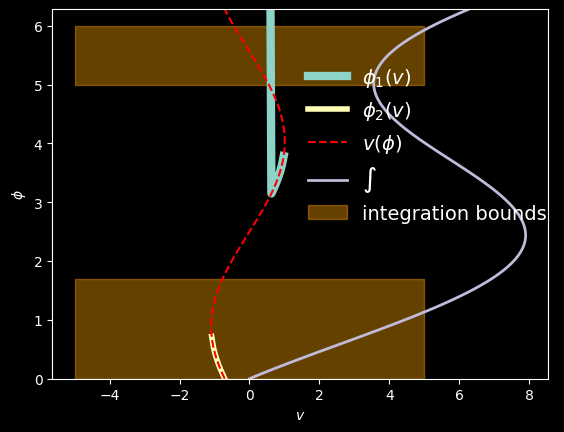

In [273]:

v = np.linspace(-5, 5, 200)

phi1, phi2 = phi_v(v, X, Y, Z)

plt.plot(v, phi1, linewidth=6, label=r'$\phi_1(v)$')
plt.plot(v, phi2, linewidth=4, label=r'$\phi_2(v)$')


phi = np.linspace(0, 2*np.pi, 100)

v1 = v_phi(phi, X, Y, Z)

plt.plot(v1, phi, linestyle='--', c="r", label=r'$v(\phi)$')

#fill between phi 5 and 5.5 horizontal
plt.fill_between(v, 5, 6, color='orange', alpha=0.4)
plt.fill_between(v, 0, 1.7, color='orange', alpha=0.4, label="integration bounds")


plt.xlabel(r'$v$')
plt.ylabel(r'$\phi$')
plt.legend(frameon=False, loc=(.5,.4), fontsize=14)
# plt.xlim(-3, 5)
plt.ylim(0, 2*np.pi);